# Linear Regression Based Model

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
import numba
from sklearn import model_selection as cv
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## About the model...

For a given user $u$ and a given movie $m$, we can write the linear model as:
$$
f(u,m) = X_{u,m} \cdot \theta
$$

Where $X_{u,m}$ is the _features vector_ for the combination $(u,m)$ and $\theta$ is the parameters vector to be learned.

The **features matrix** then is a 3-dimensional array of dimensions $U \times M \times F$, where $U$ is the number of users, $M$ the number of movies and $F$ is the number of features. 

The **predictions** then are a $U \times M$ matrix.


## About the features space

For the representation of the $(u,v)$ we choose an $48$-dimensional space (a common approach...).

The __user__ has the following features:
* __Gender__: Binarized in $2$ features
* __Age__: Binarized in $7$ features corresponding two $6$ intervals of ages.
* __Occupation__: Binarized in $21$ features corresponding to the $21$ groups of occupations
* __Zip code__ (not used)

The __movie__ has the following features:
* __Title__ (not used)
* __Genres__: Binarized in $18$ features corresponding two the $18$ available genres for movies.

In [2]:
# Load data
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python')
users = pd.read_csv('ml-1m/users.dat', sep='::', engine='python')
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python')

ratings.columns = map(str.lower, ratings.columns)
users.columns = map(str.lower, users.columns)
movies.columns = map(str.lower, movies.columns)

df = pd.merge(ratings,users)
df = pd.merge(df,movies)

# Subsampling the data
sample_size = 100000
df = df.sample(sample_size, random_state=0)
df.head()

,userid,movieid,rating,timestamp,gender,age,occupation,zip-code,title,genres
324271,1996,2406,4,974743570,M,35,0,85621,Romancing the Stone (1984),Action|Adventure|Comedy|Romance
818637,921,2071,4,975203825,M,25,17,92084,And the Band Played On (1993),Drama
148677,323,3809,4,976408046,M,45,12,53716,What About Bob? (1991),Comedy
778790,346,1390,4,976335541,F,25,0,55110,My Fellow Americans (1996),Comedy
525489,4004,3175,2,965560544,M,50,0,21050,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi


## Encoding the categorical data

In [3]:
df['gender'] = df['gender'].replace(['M','F'],[0,1])
df['genres'] = df['genres'].str.replace('|',',')
df['genres'] = df['genres'].str.replace('Action','0')
df['genres'] = df['genres'].str.replace('Adventure','1')
df['genres'] = df['genres'].str.replace('Animation','2')
df['genres'] = df['genres'].str.replace("Children's",'3')
df['genres'] = df['genres'].str.replace('Comedy','4')
df['genres'] = df['genres'].str.replace('Crime','5')
df['genres'] = df['genres'].str.replace('Documentary','6')
df['genres'] = df['genres'].str.replace('Drama','7')
df['genres'] = df['genres'].str.replace('Fantasy','8')
df['genres'] = df['genres'].str.replace('Film-Noir','9')
df['genres'] = df['genres'].str.replace('Horror','10')
df['genres'] = df['genres'].str.replace('Musical','11')
df['genres'] = df['genres'].str.replace('Mystery','12')
df['genres'] = df['genres'].str.replace('Romance','13')
df['genres'] = df['genres'].str.replace('Sci-Fi','14')
df['genres'] = df['genres'].str.replace('Thriller','15')
df['genres'] = df['genres'].str.replace('War','16')
df['genres'] = df['genres'].str.replace('Western','17')

df['age'] = df['age'].replace('1',0)
df['age'] = df['age'].replace('18',1)
df['age'] = df['age'].replace('25',2)
df['age'] = df['age'].replace('35',3)
df['age'] = df['age'].replace('45',4)
df['age'] = df['age'].replace('50',5)
df['age'] = df['age'].replace('56',6)

In [4]:
n_users = df['userid'].max(); print("Number of users: {0}".format(n_users))
n_items = df['movieid'].max(); print("Number of items: {0}".format(n_items))

Number of users: 6040
Number of items: 3952


## Splitting the data into training (75%) and test (25%) sets

In [8]:
# 75% for training
# 25% for test
df_train, df_test = cv.train_test_split(df, test_size=0.25)

## Building the features matrix

In [5]:
users = df_train['userid'].values-1
movies = df_train['movieid'].values-1
rating = df_train['rating'].values
gender = df_train['gender'].values
age = df_train['age'].values
occupation = df_train['occupation'].values
genres = df_train['genres'].values

# Building the features matrix
feat_matrix = np.zeros((n_users,n_items,48))

uid = ratings['userid'].values - 1
mid = ratings['movieid'].values - 1
rt =  ratings['rating'].values

for i in range(df.shape[0]):
    # Check gender
    u_index = uid[i]
    m_index = mid[i]
    
    if gender[i] == 0:
        feat_matrix[u_index, m_index, 0]=1
    else:
        feat_matrix[u_index, m_index ,1]=1

    # Check age
    for j in range(0,6):
        if age[i] == j:
            feat_matrix[u_index, m_index, j+2] = 1

    # Check occupation
    for k in range(0,20):
        if occupation[i] == k:
            feat_matrix[u_index, m_index, k+9] = 1

    # Check genres
    for l in range(0,17):
        if '%d' %(l) in genres[i]:
            feat_matrix[u_index, m_index, l+30]=1  

In [6]:
users = df_test['userid'].values-1
movies = df_test['movieid'].values-1
rating = df_test['rating'].values
gender = df_test['gender'].values
age = df_test['age'].values
occupation = df_test['occupation'].values
genres = df_test['genres'].values

# Building the features matrix
feat_matrix_test = np.zeros((n_users,n_items,48))

uid = ratings['userid'].values - 1
mid = ratings['movieid'].values - 1
rt =  ratings['rating'].values

for i in range(df.shape[0]):
    # Check gender
    u_index = uid[i]
    m_index = mid[i]
    
    if gender[i] == 0:
        feat_matrix_test[u_index, m_index, 0]=1
    else:
        feat_matrix_test[u_index, m_index ,1]=1

    # Check age
    for j in range(0,6):
        if age[i] == j:
            feat_matrix_test[u_index, m_index, j+2] = 1

    # Check occupation
    for k in range(0,20):
        if occupation[i] == k:
            feat_matrix_test[u_index, m_index, k+9] = 1

    # Check genres
    for l in range(0,17):
        if '%d' %(l) in genres[i]:
            feat_matrix_test[u_index, m_index, l+30]=1 

## The mapping

Most methods (in scikit-learn) require the __features matrix__ $X$ to be 2-dimensional, and the response variable to be 1-dimensional. For such reasons we perform a mapping to match this format, by flattening the arrays: 

**Each `U[u,v,:]` entry is a row of the 2-dimensional features matrix.**


In [7]:
# 3D to 2D mapping
m,n,_ = feat_matrix.shape
_feat_matrix = np.empty((m*n,48))
for i in range(m):
    for j in range(n):
        _feat_matrix[i*j,:] = feat_matrix[i,j,:]
        
# 3D to 2D mapping
m,n,_ = feat_matrix.shape
_feat_matrix_test = np.empty((m*n,48))
for i in range(m):
    for j in range(n):
        _feat_matrix_test[i*j,:] = feat_matrix_test[i,j,:]

In [8]:
# Building the predictions matrix for the training data (ground truth) 
rating_matrix = np.zeros((n_users, n_items))

for i in range(df.shape[0]):
    # Check gender
    u_index = uid[i]
    m_index = mid[i]  
    rating_matrix[u_index,m_index] = rating[i]
    
# Building the predictions matrix for the test data (ground truth) 
rating_matrix_test = np.zeros((n_users, n_items))

for i in range(df.shape[0]):
    # Check gender
    u_index = uid[i]
    m_index = mid[i]  
    rating_matrix_test[u_index,m_index] = rating[i]

In [9]:
@numba.jit()
def predict(feat_matrix, theta):
    m,n,_ = feat_matrix.shape
    pred = np.empty((m,n))
    
    for i in range(m):
        for j in range(n):
            pred[i,j] = np.dot(feat_matrix[i,j,:], theta)
    
    return pred

## The loss function
We use the MSE function to measure as loss to be minimized:
$$L(\theta) = \frac{1}{U\cdot V} \sum_{u,v} (r(u,v) - X_{u,v} \theta)^2 $$

In [10]:
def loss(y_real, y_pred):
    return np.sum((y_real-y_pred)**2)

In [12]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training set
regr.fit(_feat_matrix, rating_matrix.ravel())

# Validating the model using the training and test set
pred_rating_train = regr.predict(_feat_matrix)
pred_rating_test = regr.predict(_feat_matrix_test)

print("MSE in training set: {0}".format( mean_squared_error(pred_rating_train, rating_matrix.ravel()) ))
print("MSE in test set: {0}".format( mean_squared_error(pred_rating_test, rating_matrix_test.ravel()) ))

MSE in training set: 2.95981919
MSE in test set: 9.12108112


## Some dangerous situations...
* With the representation we choose for the the pair $(u,m)$, it is possible (but very unlikely) are all zeros:
$$
X_{u,v} = [0 \cdots 0]^T
$$
in such case, doesn't matter what is the $\theta$ parameters vector, the output/response will be always zero.
* (_More dangerous yet..._) The only features that distinguish a movie from other movie in the features space, are the genres. Then if a user $u$ has seen two movies with the same genres, these pairs $(u,v)$ will have the same features representation. 

***
***
***
***
***

# MLP (Feed Forward) Neural Network Approach 

![title](sdss_gal.jpg)

In [19]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

In [30]:
model = Sequential()
model.add(Dense(output_dim=12, input_dim=48, activation='relu', init='normal'))
model.add(Dense(output_dim=1, init='normal', activation='linear'))

# compiling the model
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 12)                588       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


### Network Description:
* 12 __hidden units__
* __relu__ activation functions
* weights initialized with __normal distribution__
* output layer is __linear__
* Optimization method is __Stochastic Gradient Descent__ with _learning rate_ 0.1
* loss function is the __MSE__

In [57]:
# fitting the model
hist = model.fit(_feat_matrix, rating_matrix.ravel(), nb_epoch=10, 
                   verbose=0, validation_data=(_feat_matrix_test, rating_matrix_test))

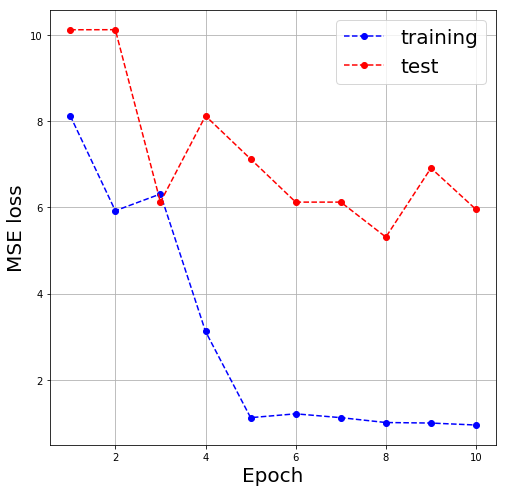

In [49]:
plt.figure(figsize=(8,8))
plt.plot(list(range(1,11)), hist['loss'], 'bo--', label='training')
plt.plot(list(range(1,11)), hist['val_loss'], 'ro--', label='test')
plt.grid()
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE loss', fontsize=20)
plt.legend(loc='best', prop={'size': 20})
plt.show()

In [54]:
s1 = model.evaluate(_feat_matrix, rating_matrix.ravel(), verbose=0)
s2 = model.evaluate(_feat_matrix_test, rating_matrix_test.ravel(), verbose=0)
print("MSE in training set: {0}".format(s1)) 
print("MSE in test set: {0}".format(s2)) 

MSE in training set: 0.951981
MSE in test set: 5.951981


 | **MSE LR** | **MSE MLP**
--- | --- | ---
** Train ** | 2.95981919 | 0.951981
** Test ** | 9.12108112 | 5.951981

## Some other difficulties
* __Different approches use different metrics__ to compare the accuracy of its predictions
* Some approaches modify the range of the ratings (1-5), making it even more difficult to compare